CODIFICAR PARA ESCALA DE GRISES

In [1]:
import numpy as np
from PIL import Image
import struct
import matplotlib.pyplot as plt


def escribeIm(x, nombre):
    """
    x: numpy array de tipo uint8 con la imagen en escala de grises [0..255].
    nombre: nombre del fichero binario donde se almacenará la imagen codificada.
    """
    filas, columnas = x.shape

    with open(nombre, "wb") as fid:
        # 1) Escribimos el número de filas (16 bits)
        # Utilizamos struct para empacar en formato little-endian ('<')
        # 'H' (unsigned short) => 16 bits sin signo
        fid.write(struct.pack("<H", filas))

        # 2) Escribimos el número de columnas (16 bits)
        fid.write(struct.pack("<H", columnas))

        # 3) Escribimos los píxeles en orden de columnas
        # En MATLAB, fread/fwrite con matrices lo hace por columnas,
        # mientras que en NumPy (row-major) x.flatten() sería por filas.
        # Para imitar al 100% la escritura por COLUMNAS, podemos trasponer x y luego hacer un flatten:
        x_col_major = (
            x.T.flatten()
        )  # flatten() -> saca un vector en orden row-major, pero de la imagen traspuesta.

        # Ahora escribimos esos bytes:
        x_col_major.tofile(fid)  # Equivalente a un fwrite de todos los datos.


im_rgb = Image.open("../data/i1.png").convert("L")  # "L" => 8 bits (grayscale)
x = np.array(im_rgb, dtype=np.uint8)  # Convertimos a numpy array

# Codificar la imagen a un fichero binario
escribeIm(x, "1i.bin")  # El nombre "i1i.bin" es el "fichero codificado"

print("Fichero 'i1i.bin' generado con cabecera + datos de imagen.")


# numero de filas maximo que puede tener la imagen a codificar
max_filas = 65535  # 2^16 - 1
# numero de columnas maximo que puede tener la imagen a codificar
max_columnas = 65535  # 2^16 - 1

Fichero 'i1i.bin' generado con cabecera + datos de imagen.


DECODIFICAR EN ESCALA DE GRISES

Dimensiones imagen decodificada: (708, 512)


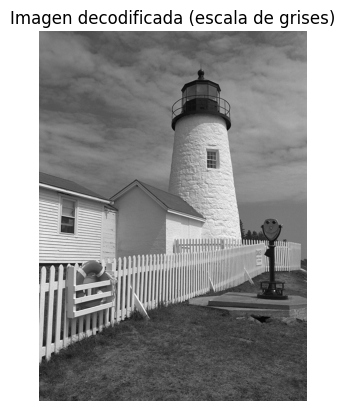

In [2]:
def leeIm(nombre):
    """
    nombre: nombre del fichero binario con la secuencia de bits a decodificar.
    Retorna la imagen decodificada (numpy array uint8).
    """
    with open(nombre, "rb") as fid:
        # 1) Leer f y c como uint16
        contenido = fid.read(2)  # leer 2 bytes -> f
        f = struct.unpack("<H", contenido)[0]

        contenido = fid.read(2)  # leer 2 bytes -> c
        c = struct.unpack("<H", contenido)[0]

        # 2) Leer f*c bytes (uint8)
        num_pix = f * c
        # leemos en binario
        datos = fid.read(num_pix)
        # Convertir a array numpy
        arr = np.frombuffer(datos, dtype=np.uint8)

        # 3) Reconstruir la matriz en orden de columnas.
        # En MATLAB, fread(...,[f c],'uint8') rellena la matriz por columnas.
        # Para imitarlo:
        #   - arr es un vector de tamaño f*c
        #   - lo interpretamos como c columnas y f filas en row-major
        #   - luego lo trasponemos
        arr_2d_col = arr.reshape((c, f)).T  # Ahora es (f, c)

        # arr_2d_col es la imagen final
        return arr_2d_col


def ejemplo_leeIm():
    y = leeIm("1i.bin")
    print("Dimensiones imagen decodificada:", y.shape)

    # Mostrar imagen decodificada (escala de grises)
    plt.imshow(y, cmap="gray")
    plt.title("Imagen decodificada (escala de grises)")
    plt.axis("off")
    plt.show()


ejemplo_leeIm()

CODIFICADOR/DECODFICADOR PARA IMÁGENES RGB

In [3]:
def rgb_to_y(im_rgb):
    """
    Convierte array RGB (uint8) a su luminancia Y (uint8).

    Podrías usar una fórmula como:
       Y = 0.299 R + 0.587 G + 0.114 B
    redondeando al uint8.
    """
    # im_rgb: (filas, cols, 3) en uint8
    R = im_rgb[:, :, 0].astype(np.float32)
    G = im_rgb[:, :, 1].astype(np.float32)
    B = im_rgb[:, :, 2].astype(np.float32)

    Y_float = 0.299 * R + 0.587 * G + 0.114 * B
    Y = np.clip(Y_float, 0, 255).astype(np.uint8)

    return Y


def escribeRGB(nombre_im, nombre_sb, color=1):
    """
    nombre_im: fichero de imagen en disco (por ej. 'i1.png')
    nombre_sb: nombre del fichero binario de salida
    color: 1 => codifica R, G, B (24 bpp); 0 => codifica solo la componente Y (8 bpp).
    """
    # 1) Leemos la imagen con Pillow
    im = Image.open(nombre_im).convert("RGB")  # Aseguramos que está en RGB
    arr = np.array(im, dtype=np.uint8)  # (f, c, 3)

    f, c, _ = arr.shape

    with open(nombre_sb, "wb") as fid:
        # Escribimos un indicador en la cabecera: color o no
        # Para simplificar, 1 byte con color (1 ó 0)
        fid.write(struct.pack("B", color))

        # Escribimos f y c (uint16)
        fid.write(struct.pack("<H", f))
        fid.write(struct.pack("<H", c))

        if color == 1:
            # Codificamos R, G y B => 3 canales => 24 bits/píxel
            # (f,c,3). Queremos escribir cada canal en orden R->G->B
            # y por columnas.

            # Separamos
            R = arr[:, :, 0]
            G = arr[:, :, 1]
            B = arr[:, :, 2]

            # Usaremos la misma lógica de "column-major":
            R_flat_col = R.T.flatten()
            G_flat_col = G.T.flatten()
            B_flat_col = B.T.flatten()

            # Escribimos consecutivamente
            R_flat_col.tofile(fid)
            G_flat_col.tofile(fid)
            B_flat_col.tofile(fid)

        else:
            # color == 0 => Solo guardamos la componente Y (8 bpp)
            Y = rgb_to_y(arr)
            Y_flat_col = Y.T.flatten()
            Y_flat_col.tofile(fid)


# ejemplo de uso
escribeRGB("../data/i1.png", "1i_rgb.bin", color=1)
print("Fichero '1i_rgb.bin' generado con cabecera + datos de imagen RGB.")

Fichero '1i_rgb.bin' generado con cabecera + datos de imagen RGB.


Forma out_color: (708, 512, 3)


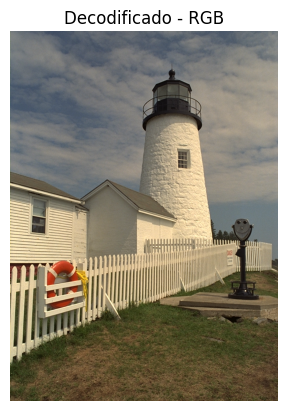

In [6]:
def leeRGB(nombre_sb):
    with open(nombre_sb, "rb") as fid:
        # 1) Leemos color (1 byte)
        contenido = fid.read(1)
        color_flag = struct.unpack("B", contenido)[0]

        # 2) Leemos f y c (16 bits cada uno)
        contenido = fid.read(2)
        f = struct.unpack("<H", contenido)[0]
        contenido = fid.read(2)
        c = struct.unpack("<H", contenido)[0]

        if color_flag == 1:
            # 3 canales
            num_pix = f * c
            # Leemos R, G, B por columnas
            R_data = fid.read(num_pix)
            G_data = fid.read(num_pix)
            B_data = fid.read(num_pix)

            R_arr = np.frombuffer(R_data, dtype=np.uint8).reshape((c, f)).T
            G_arr = np.frombuffer(G_data, dtype=np.uint8).reshape((c, f)).T
            B_arr = np.frombuffer(B_data, dtype=np.uint8).reshape((c, f)).T

            # Reconstruir la imagen
            out = np.stack([R_arr, G_arr, B_arr], axis=2)  # (f, c, 3)

        else:
            # Solo luminancia
            num_pix = f * c
            Y_data = fid.read(num_pix)
            Y_arr = np.frombuffer(Y_data, dtype=np.uint8).reshape((c, f)).T

            # Convertimos a (f,c,3) replicando la luminancia en R=G=B si queremos mostrarla en color
            # o la dejamos en 2D. Para imshow en escala de grises con matplotlib, nos basta 2D.
            # Sin embargo, la práctica dice que la imagen se mostrará en gama de grises.
            out = Y_arr  # 2D

    return out


# ejemplo de uso
out_color = leeRGB("1i_rgb.bin")
print("Forma out_color:", out_color.shape)  # (f, c, 3)
plt.figure()
plt.imshow(out_color)
plt.title("Decodificado - RGB")
plt.axis("off")
plt.show()

In [ ]:
def image_to_binary(image, export_file: str, color: bool = False):

    # Cargar la imagen
    rows, columns, channels = image.shape

    # Normalizar si es necesario
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)
    elif image.dtype != np.uint8:
        image = image.astype(np.uint8)

    # Convertir a escala de grises si solo se necesita la componente Y
    if not color:
        # Usar ponderación para calcular la luminancia (Y)
        image = np.dot(image[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

    # Escribir en el archivo binario
    with open(export_file, "wb") as fid:
        # Escribir dimensiones y número de canales como uint16
        fid.write(np.uint16(rows).tobytes())
        fid.write(np.uint16(columns).tobytes())
        fid.write(np.uint16(channels).tobytes())

        # Escribir los datos de los canales en el orden R, G, B
        if color:
            fid.write(image[..., 0].tobytes())  # Componente R
            fid.write(image[..., 1].tobytes())  # Componente G
            fid.write(image[..., 2].tobytes())  # Componente B
        else:
            fid.write(image.tobytes())  # Solo la componente Y


# def save_image_as_png(image: np.ndarray, output_file: str):
#     """
#     Saves a numpy array as a PNG image.
#     """
#     # Use PIL to save the image
#     img = Image.fromarray(image)
#     img.save(output_file, format="PNG")


def binary_to_image(binary_file: str, color: bool = False):
    """
    Reads a binary file and returns a black and white version of the image.
    """
    # Open the file in binary read mode
    with open(binary_file, "rb") as fid:
        # Read the number of rows, columns, and channels as uint16
        rows = int(np.frombuffer(fid.read(2), dtype=np.uint16)[0])
        columns = int(np.frombuffer(fid.read(2), dtype=np.uint16)[0])
        channels = int(np.frombuffer(fid.read(2), dtype=np.uint16)[0])

        # Read the image data
        data = np.frombuffer(fid.read(rows * columns * channels), dtype=np.uint8)

        if channels == 3 and color:
            # Reconstruir RGB
            image = np.zeros((rows, columns, 3), dtype=np.uint8)
            image[..., 0] = data[: rows * columns].reshape((rows, columns))  # R
            image[..., 1] = data[rows * columns : 2 * rows * columns].reshape(
                (rows, columns)
            )  # G
            image[..., 2] = data[2 * rows * columns :].reshape((rows, columns))  # B
        elif channels == 1 or not color:
            image = data.reshape((rows, columns))
        else:
            raise ValueError("Unexpected channel configuration in binary file.")

        return image